# TECHNICAL CHALLENGE: Probability of default: credit scoring model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

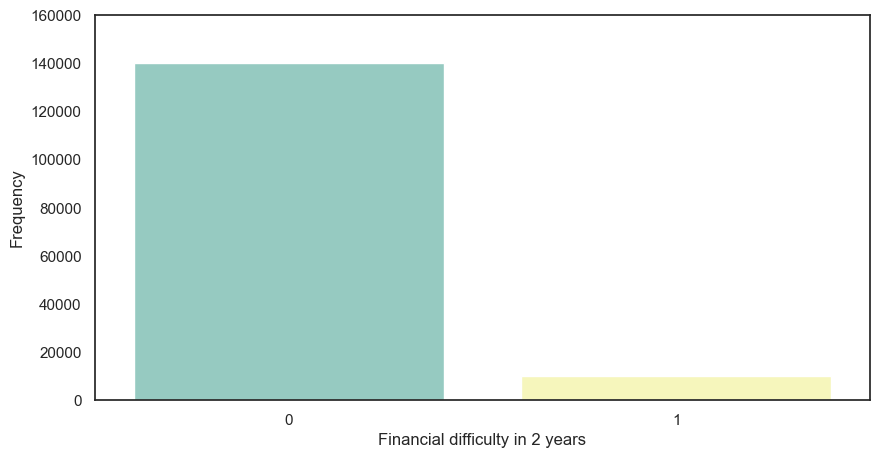

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247976 entries, 0 to 247975
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unknown        247976 non-null  int64  
 1   Target         146473 non-null  float64
 2   UnsecLines     247976 non-null  int8   
 3   age            247976 non-null  int8   
 4   Late3059       247976 non-null  int64  
 5   DebtRatio      247976 non-null  int8   
 6   MonthlyIncome  247976 non-null  int8   
 7   OpenCredit     247976 non-null  int8   
 8   Late90         247976 non-null  int64  
 9   PropLines      247976 non-null  int64  
 10  Late6089       247976 non-null  int64  
 11  Deps           247976 non-null  float64
dtypes: float64(2), int64(5), int8(5)
memory usage: 14.4 MB


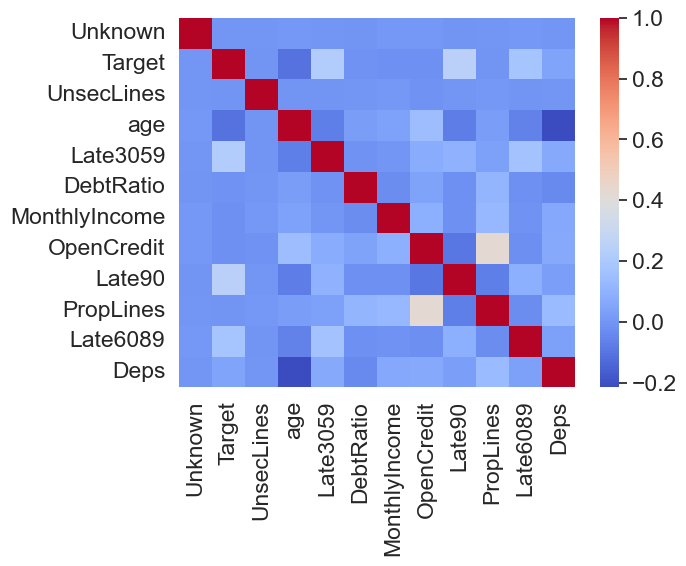

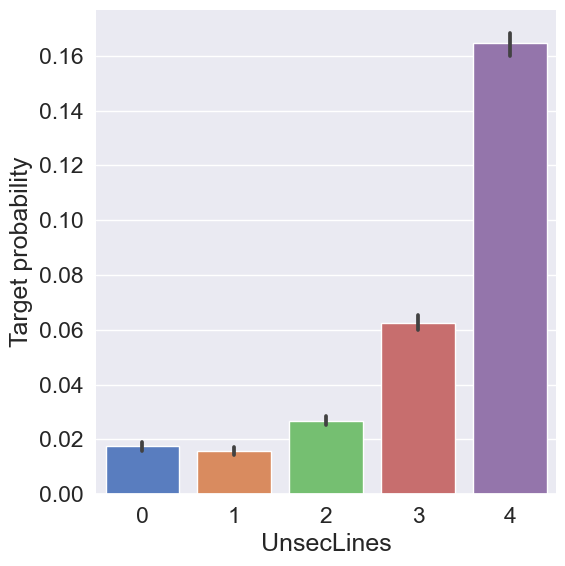

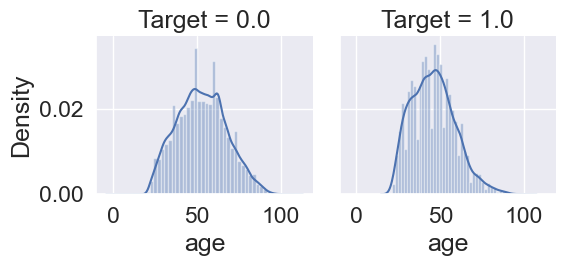

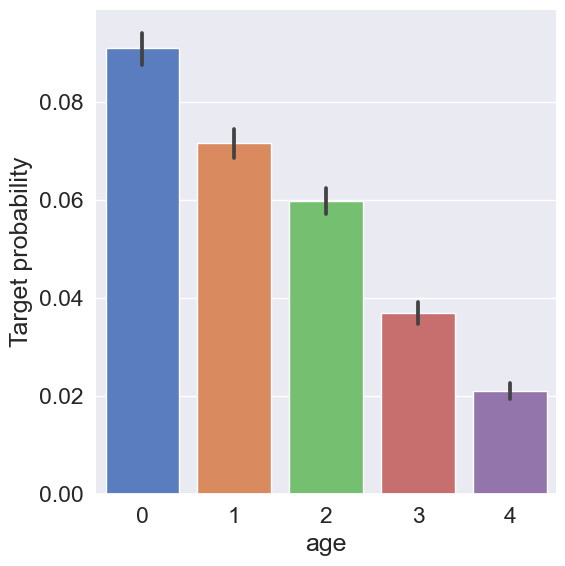

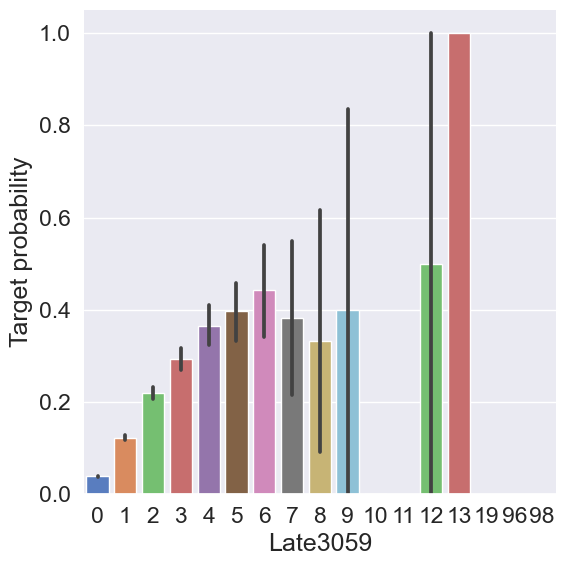

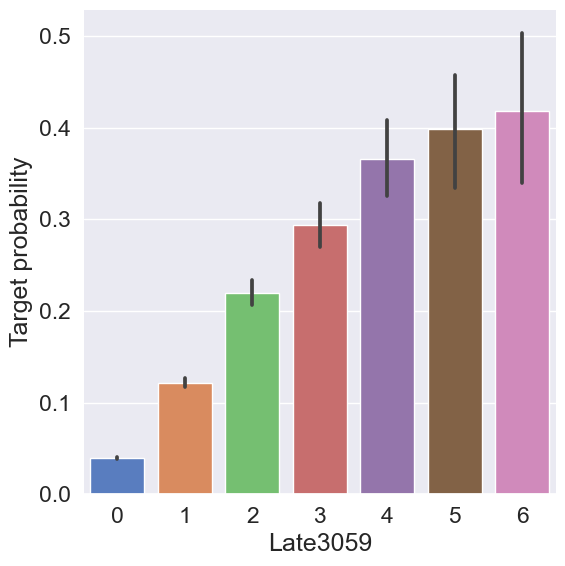

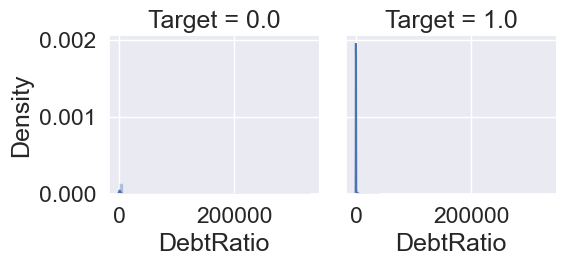

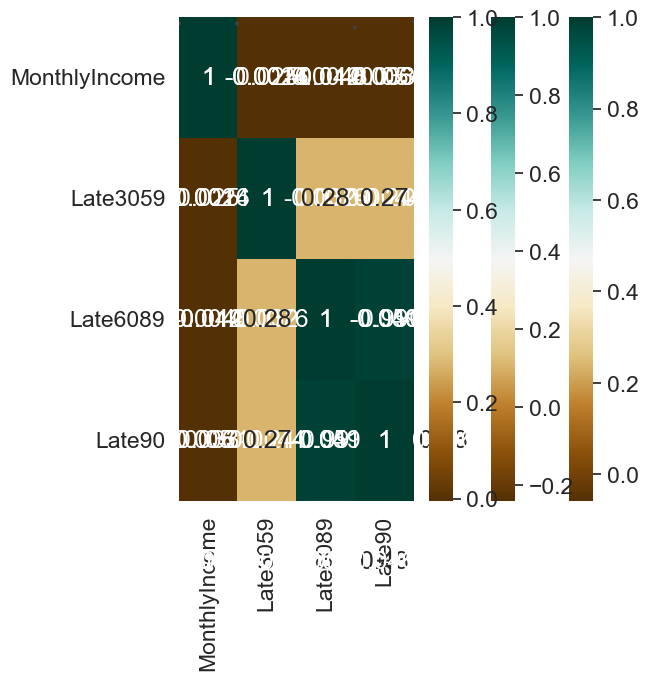

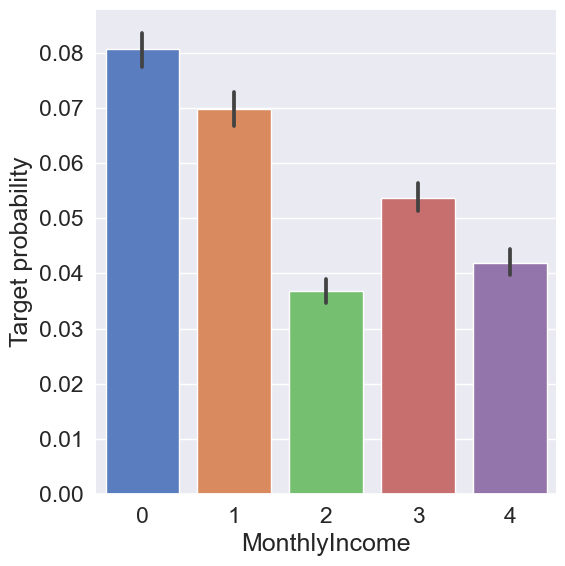

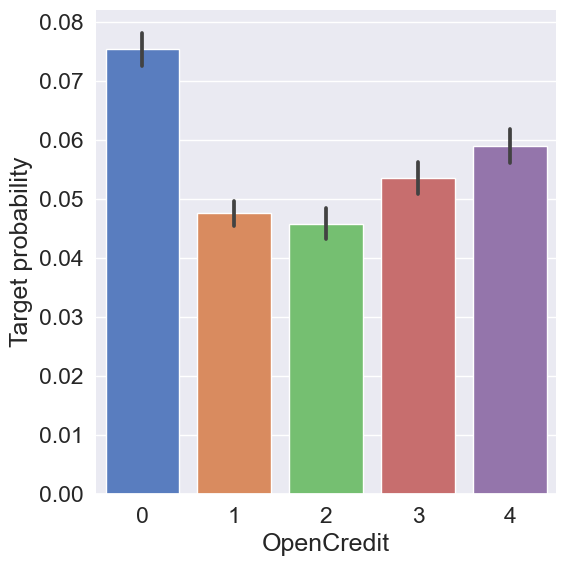

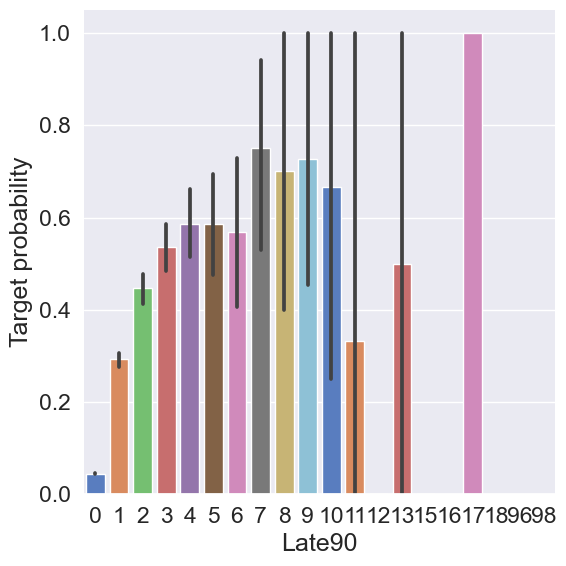

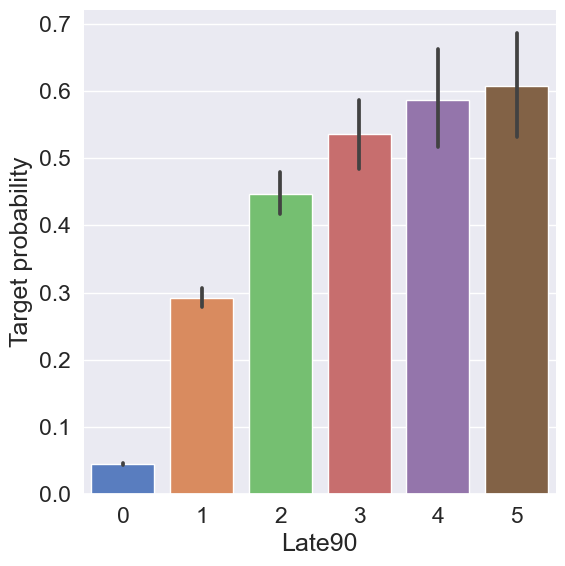

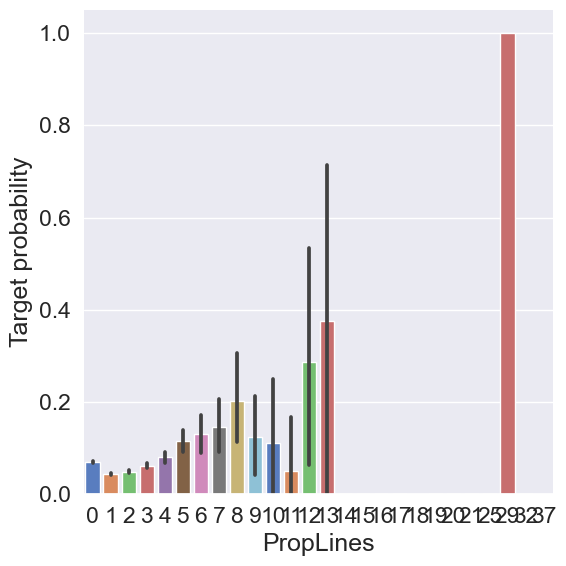

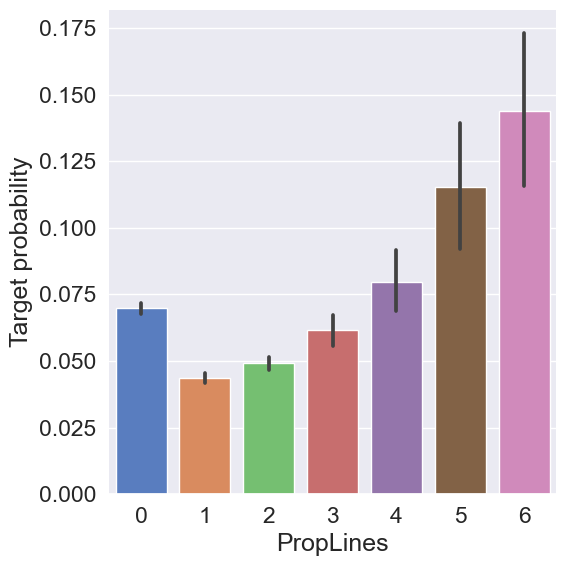

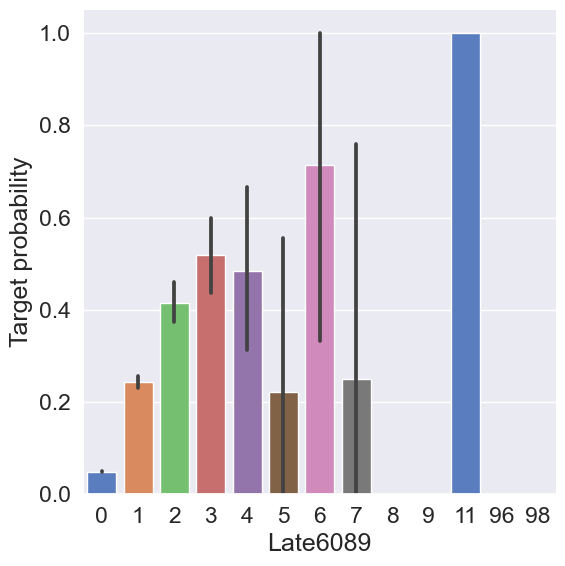

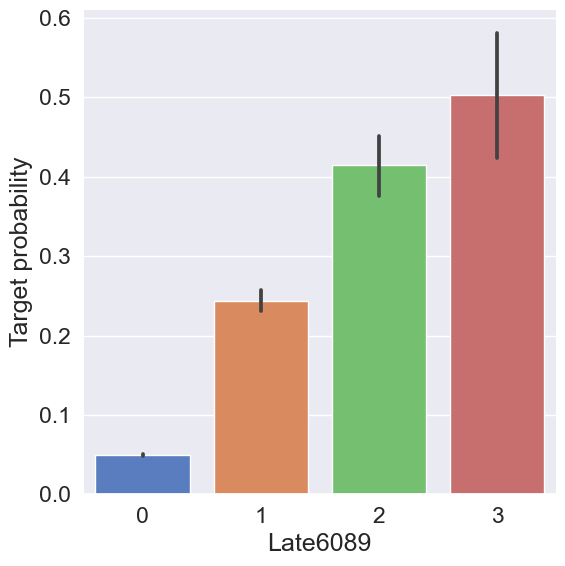

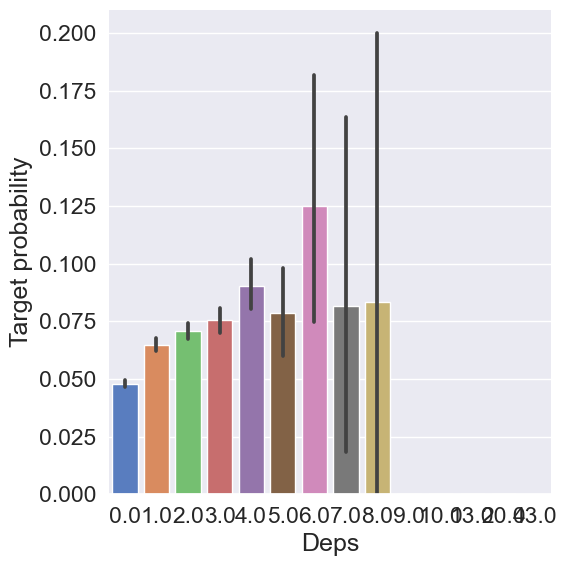

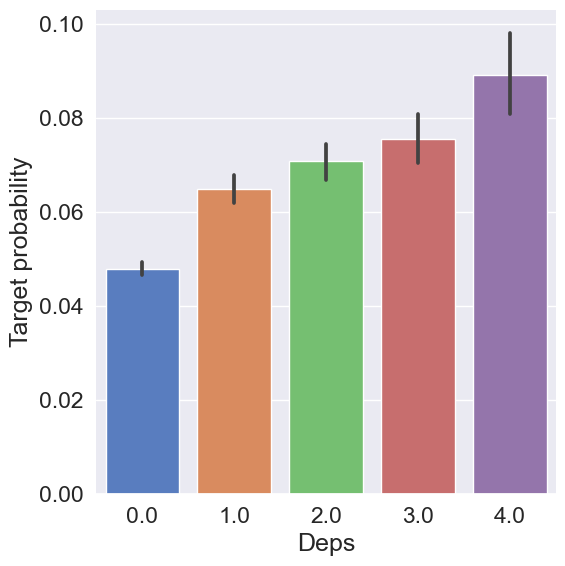

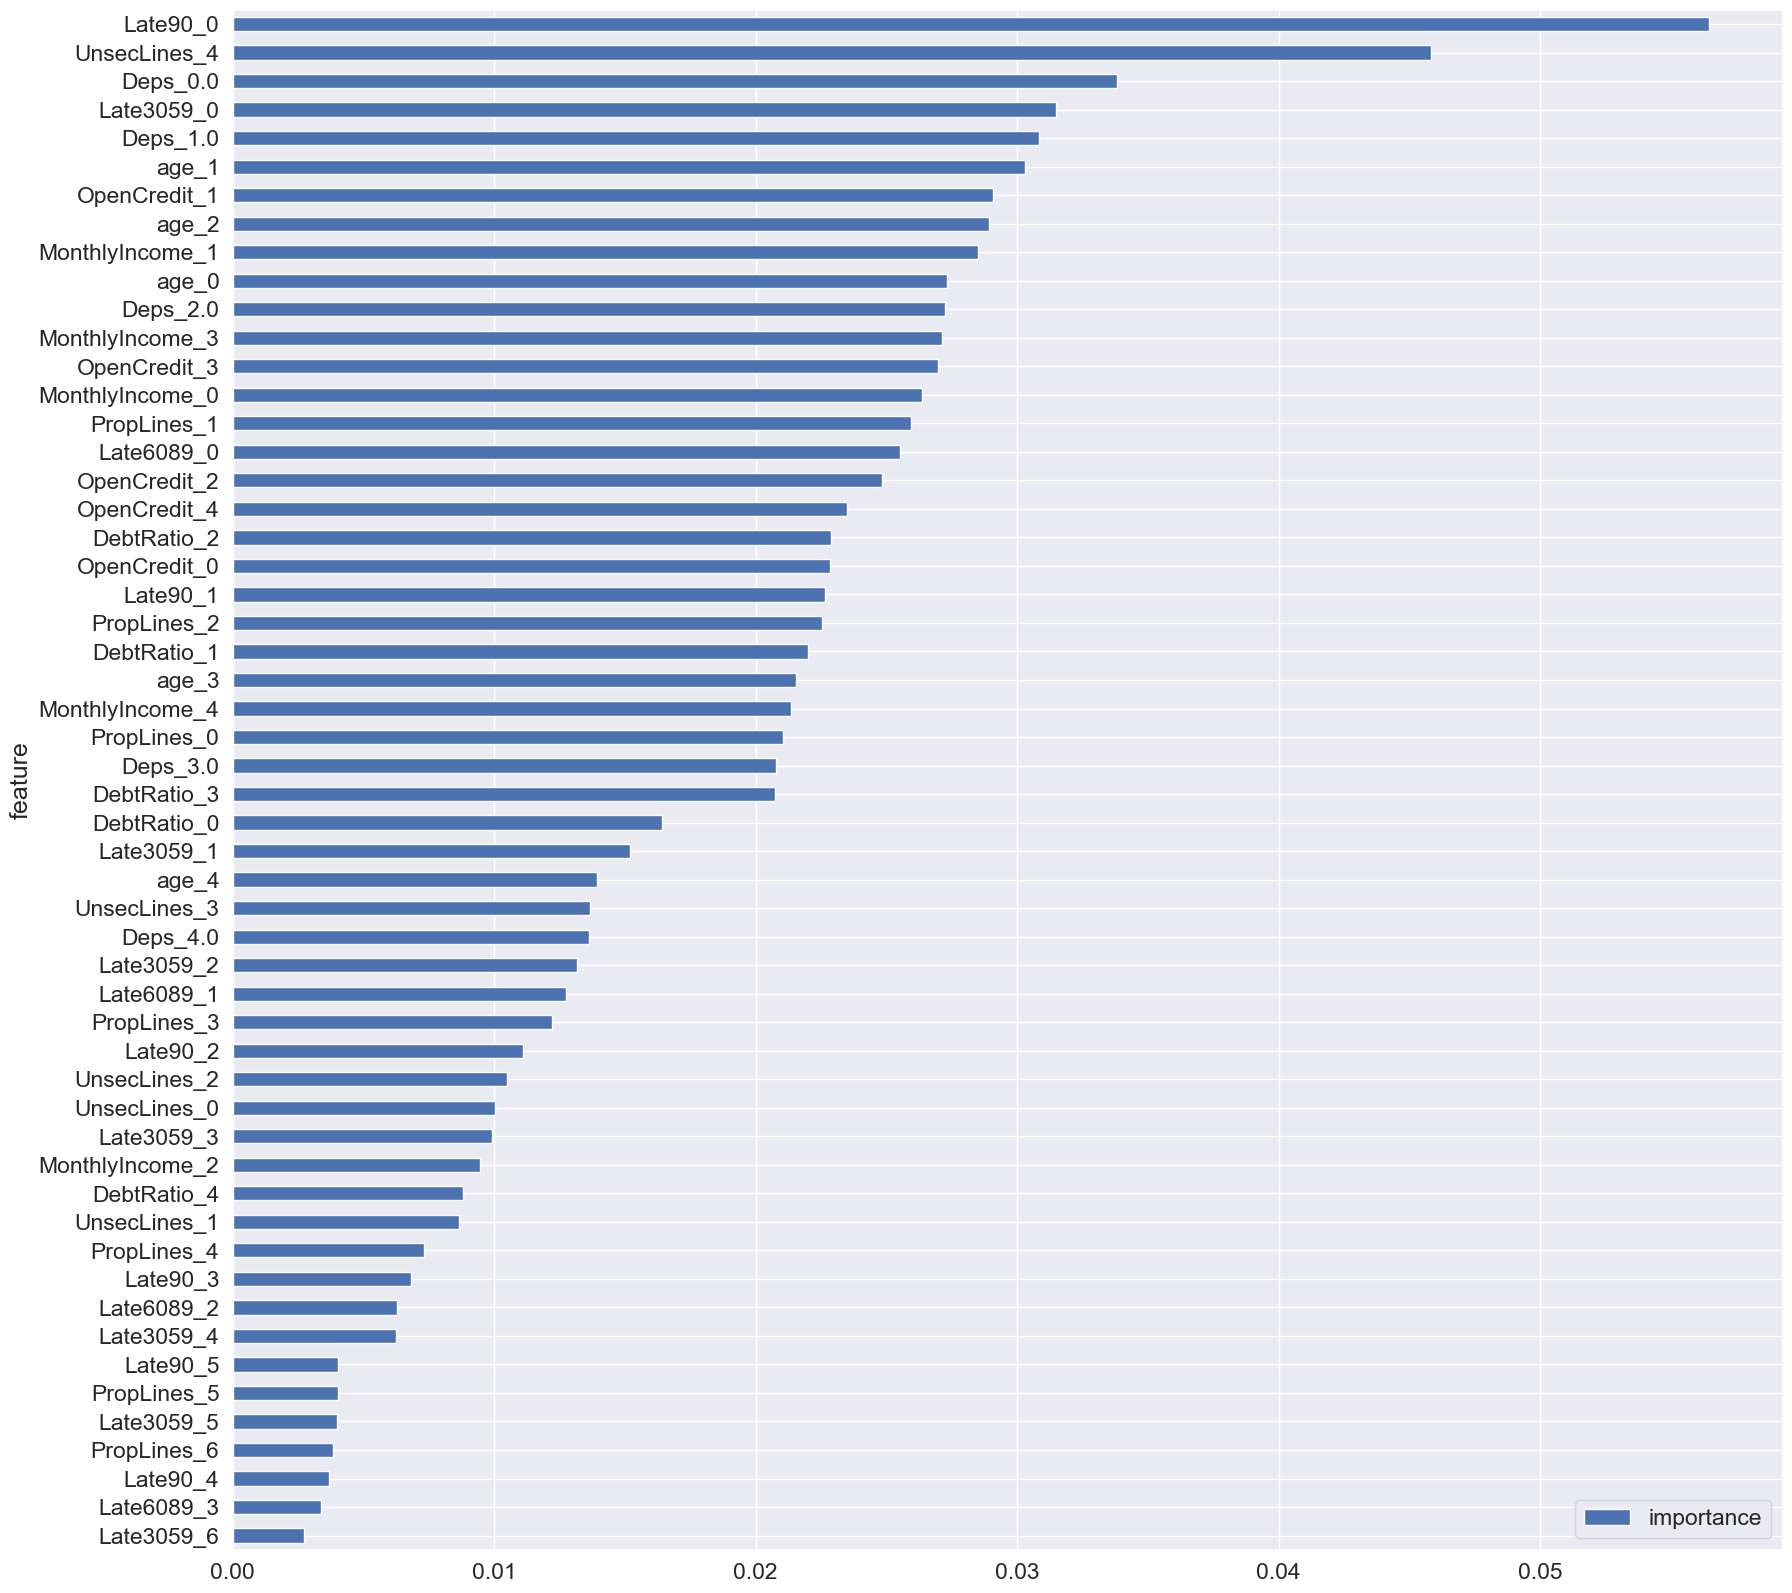

In [3]:
# Load libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import yaml

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

import pickle
# Exploratory Data Analysis
train = pd.read_csv("data\\cs-training.csv")
test_set = pd.read_csv("data\\cs-test.csv")

train.head()
train.shape
train.describe()
train.info()
train.isnull().sum()

test_set.isnull().sum()

### Target distribution
ax = sns.countplot(x = train.SeriousDlqin2yrs ,palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel('Financial difficulty in 2 years')
ax.set_ylabel('Frequency')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

plt.show()

### Detecting outliers
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(train,2,["RevolvingUtilizationOfUnsecuredLines",
                                            "age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "DebtRatio",
                                            "MonthlyIncome",
                                            "NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "Unnamed: 0",
                                            "NumberOfDependents"])
train.loc[Outliers_to_drop]

train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
## Merging datasets
train_len = len(train)
dataset =  pd.concat(objs=[train, test_set], axis=0).reset_index(drop=True)
dataset.shape
dataset = dataset.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

train = train.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

test_set = test_set.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})
## Exploring variables
# Correlation matrix
g = sns.heatmap(train.corr(),annot=False, fmt = ".2f", cmap = "coolwarm")

## Exploring UnsecLines
dataset.UnsecLines.describe()
dataset.UnsecLines = pd.qcut(dataset.UnsecLines.values, 5).codes
# Explore UnsecLines feature vs Target
g  = sns.catplot(x="UnsecLines",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

## Exploring Age
# Explore Age vs Survived
g = sns.FacetGrid(dataset, col='Target')
g = g.map(sns.distplot, "age")
dataset.age = pd.qcut(dataset.age.values, 5).codes
# Explore age feature vs Target
g  = sns.catplot(x="age",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
# Explore UnsecLines feature vs Target
g  = sns.catplot(x="Late3059",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
for i in range(len(dataset)):
    if dataset.Late3059[i] >= 6:
        dataset.Late3059[i] = 6
# Explore UnsecLines feature vs Target
g  = sns.catplot(x="Late3059",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")


## Exploring DebtRatio
# Explore Age vs Survived
g = sns.FacetGrid(dataset, col='Target')
g = g.map(sns.distplot, "DebtRatio")
dataset.DebtRatio = pd.qcut(dataset.DebtRatio.values, 5).codes
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="DebtRatio",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
## Exploring MonthlyIncome
dataset.MonthlyIncome.isnull().sum()
g = sns.heatmap(dataset[["MonthlyIncome","Unknown","UnsecLines","OpenCredit","PropLines"]].corr(),cmap="BrBG",annot=True)
g = sns.heatmap(dataset[["MonthlyIncome","age","DebtRatio","Deps","Target"]].corr(),cmap="BrBG",annot=True)
g = sns.heatmap(dataset[["MonthlyIncome","Late3059","Late6089","Late90"]].corr(),cmap="BrBG",annot=True)

dataset.MonthlyIncome.median()
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset.MonthlyIncome = dataset.MonthlyIncome.fillna(dataset.MonthlyIncome.median())
dataset.MonthlyIncome = pd.qcut(dataset.MonthlyIncome.values, 5).codes
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="MonthlyIncome",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
## Exploring OpenCredit
dataset.OpenCredit.describe()
dataset.OpenCredit = pd.qcut(dataset.OpenCredit.values, 5).codes
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="OpenCredit",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
## Exploring Late90
dataset.Late90.describe()
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="Late90",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
for i in range(len(dataset)):
    if dataset.Late90[i] >= 5:
        dataset.Late90[i] = 5
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="Late90",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
## Exploring PropLines
dataset.PropLines.describe()
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="PropLines",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
for i in range(len(dataset)):
    if dataset.PropLines[i] >= 6:
        dataset.PropLines[i] = 6
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="PropLines",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
## Exploring Late6089
# Explore Late6089 feature quantiles vs Target
g  = sns.catplot(x="Late6089",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
for i in range(len(dataset)):
    if dataset.Late6089[i] >= 3:
        dataset.Late6089[i] = 3
# Explore Late6089 feature quantiles vs Target
g  = sns.catplot(x="Late6089",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
## Exploring Deps
dataset.Deps.describe()
dataset.Deps = dataset.Deps.fillna(dataset.Deps.median())
dataset.Deps.isnull().sum()
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="Deps",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
for i in range(len(dataset)):
    if dataset.Deps[i] >= 4:
        dataset.Deps[i] = 4
# Explore DebtRatio feature quantiles vs Target
g  = sns.catplot(x="Deps",y="Target",data=dataset,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")
## Final NaN check
dataset.info()
dataset.head()

dataset = pd.get_dummies(dataset, columns = ["UnsecLines"], prefix="UnsecLines")
dataset = pd.get_dummies(dataset, columns = ["age"], prefix="age")
dataset = pd.get_dummies(dataset, columns = ["Late3059"], prefix="Late3059")
dataset = pd.get_dummies(dataset, columns = ["DebtRatio"], prefix="DebtRatio")
dataset = pd.get_dummies(dataset, columns = ["MonthlyIncome"], prefix="MonthlyIncome")
dataset = pd.get_dummies(dataset, columns = ["OpenCredit"], prefix="OpenCredit")
dataset = pd.get_dummies(dataset, columns = ["Late90"], prefix="Late90")
dataset = pd.get_dummies(dataset, columns = ["PropLines"], prefix="PropLines")
dataset = pd.get_dummies(dataset, columns = ["Late6089"], prefix="Late6089")
dataset = pd.get_dummies(dataset, columns = ["Deps"], prefix="Deps")
dataset.head()
dataset.shape
## Building our credit scoring model
train = dataset[:train_len]
test_set = dataset[train_len:]
test_set.drop(labels=["Target"],axis = 1,inplace=True)
test_set.shape
## Separate train features and label 

train["Target"] = train["Target"].astype(int)

Y_train = train["Target"]

X_train = train.drop(labels = ["Target", "Unknown"],axis = 1)
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, Y_train)
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(20, 20))
parameters = {'n_estimators': 1000, 'random_state' : 20}
    
model = RandomForestClassifier(**parameters)
model.fit(X_train, Y_train)
test_set.head()
results_df = pd.read_csv("data\\cs-test.csv")

results_df = results_df.drop(["RevolvingUtilizationOfUnsecuredLines",
                             "age",
                             "NumberOfTime30-59DaysPastDueNotWorse",
                             "DebtRatio",
                             "MonthlyIncome",
                             "NumberOfOpenCreditLinesAndLoans",
                             "NumberOfTimes90DaysLate",
                             "NumberRealEstateLoansOrLines",
                             "NumberOfTime60-89DaysPastDueNotWorse",
                             "NumberOfDependents"], axis=1)
DefaultProba = model.predict_proba(test_set.drop(["Unknown"], axis=1))
DefaultProba = DefaultProba[:,1]
results_df.SeriousDlqin2yrs = DefaultProba

results_df = results_df.rename(columns={'Unnamed: 0': 'Id',
                                        'SeriousDlqin2yrs': 'Probability'})
results_df.head()
results_df.to_csv("PREDICTED_CREDIT_SCORE.csv", index=False)

# save the model as a .pkl file
import joblib
with open('../api/model/model.pkl', 'wb') as f:
    joblib.dump(model, '../api/model/model.pkl')

